# AMLD workshop by L2F–Learn to Forecast

Welcome to the "Machine Learning Competition" workshop at AMLD 2019, organized by L2F–Learn to Forecast!

We will work with a dataset of tennis matches, with a shot-by-shot description of each point. We will focus on the two Swiss tennis stars: Roger Federer and Stanislas Wawrinka. 

The goals of this workshop are two-fold:

+ Predict the outcome (win/lose) of a rally (sequence of shots).
+ Develop a coaching strategy to help Roger and Stan improve. 

This notebook contains a rudimentary analysis to help you get started. Good luck :)

In [53]:
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Data from Jeff Sackmann's GitHub

(See Excel sheet 'MatchChart 0.2.0' for full description)

Each row is one point.
Volunteers manually input the rally in the '1st' or '2nd' column, depending on wether it's a first or second serve (the other features, like the score, are automatically populated).

Numbers are used to indicate direction and depth, while letters are used to specific shot types (e.g. 'f' stands for 'forehand') and error types ('n' stands for 'net').  

A few symbols are used for other purposes, such as types of errors (e.g. '@' means 'unforced error' and '+' indicates an approach shot).

See README for more detail.

In [2]:
df = pd.read_csv('charting-m-points_clean.csv',
                 encoding='latin1',
                 dtype={'Gm#': str, 'TB?': str, 'rallyCount': str})   # Specify dtype for some mixed columns)
df.columns

Index(['Unnamed: 0', 'match_id', 'Pt', 'Set1', 'Set2', 'Gm1', 'Gm2', 'Pts',
       'Gm#', 'TbSet', 'TB?', 'TBpt', 'Svr', 'Ret', 'Serving', '1st', '2nd',
       'Notes', '1stNoLet', '2ndNoLet', '1stSV', '2ndSV', '1stNoSV', '2ndNoSV',
       '1stIn', '2ndIn', 'isRally1st', 'isRally2nd', 'Sv1', 'Sv2', 'isAce',
       'isUnret', 'isRallyWinner', 'isForced', 'isUnforced', 'isDouble',
       'rallyNoSpec', 'rallyNoError', 'rallyNoDirection', 'rallyLen',
       'PtWinner', 'isSvrWinner', 'PtsAfter', 'GmW', 'Gm1.1', 'Gm2.1', 'SetW',
       'Set1.1', 'Set2.1', 'RevTB', 'TBrev', 'rallyCount'],
      dtype='object')

In [3]:
# Examples of sequences of shots

df[['1st', '2nd']].head()

,1st,2nd
0,6*,NaN
1,4n,6f27b2b2b3b3b2b3b3b3w@
2,4f38b+3s2v1*,NaN
3,6f37b+3s2h1w#,NaN
4,4r3w#,NaN


A second match summary dataset which might be of use. This is a cleaned-up version of the file in https://github.com/JeffSackmann/tennis_MatchChartingProject/blob/master/charting-m-matches.csv

In [4]:
df_match = pd.read_csv('charting-m-matches_clean.csv')
assert set(df.match_id).intersection(set(df_match.match_id)) == set(df.match_id)  # Checking that all match ids in the point-by-point dataset are accounted for in the summary dataset
df_match.head()

,match_id,Player 1,Player 2,Pl 1 hand,Pl 2 hand,Gender,Date,Tournament,Round,Time,Court,Surface,Umpire,Best of,Final TB?,Charted by
0,20181104-M-Paris_Masters-F-Novak_Djokovic-Kare...,Novak Djokovic,Karen Khachanov,R,R,M,20181104,Paris Masters,F,3pm,Centre,Carpet,Cedric Mourier,3,1,Edo
1,20181103-M-Paris_Masters-SF-Novak_Djokovic-Rog...,Novak Djokovic,Roger Federer,R,R,M,20181103,Paris Masters,SF,4:00 PM,Centre,Hard,Carlos Bernardes,3,1,Palaver
2,20181101-M-Paris_Masters-R16-Dominic_Thiem-Bor...,Dominic Thiem,Borna Coric,R,R,M,20181101,Paris Masters,R16,4:35 PM,Centre,Hard,Nacho Forcadell,3,1,ChapelHeel66
3,20181101-M-Paris_Masters-R16-Diego_Sebastian_S...,Diego Sebastian Schwartzman,Alexander Zverev,R,R,M,20181101,Paris Masters,R16,NaN,NaN,Hard,Carlos Bernardes,3,1,Isaac
4,20181031-M-Paris_Masters-R32-Daniil_Medvedev-B...,Daniil Medvedev,Borna Coric,R,R,M,20181031,Paris Masters,R32,11:30 AM,Centre,Hard,Nacho Forcadell,3,1,ChapelHeel66


# Data preparation

We begin by spliting the *match_id* strings into separate features.

In [5]:
df[['Date','Sex','Tournament','Stage','Player1','Player2']] = df['match_id'].str.split('-', expand=True)

We now split sequences in columns *1st* or *2nd* into a rally (which includes the serve) and an outcome. 

In [6]:
def rally_outcome(sequence):
    # Special situations
    if pd.isnull(sequence):
        return np.nan, np.nan
    if sequence in {'S', 'Q'}:
        return '0', '*'
    if sequence in {'R', 'P', 'V'}:
        return '0', '@'
    # "Regular" rally endings
    for i in range(len(sequence)):
        if sequence[i] in ['n','w','d','x','g','e','!','*','#','@']:
            return sequence[:i], sequence[i:]
    return None, None

df['1stRally'], df['1stOutcome'] = zip(*df['1st'].map(rally_outcome))
df['2ndRally'], df['2ndOutcome'] = zip(*df['2nd'].map(rally_outcome))

Our final rallies and outcomes are selected from the first serve if there was no second serve, and from the second otherwise.

In [7]:
df['Null2ndRally'] = df['2ndRally'].isnull()
df['Rally'] = df['1stRally'].where(df['Null2ndRally'], other=df['2ndRally'])
df['Outcome'] = df['1stOutcome'].where(df['Null2ndRally'], other=df['2ndOutcome'])
df['Null2ndRally'] = df['Null2ndRally'].astype(int)

In [8]:
df['Outcome'].unique() #####  STILL TYPOS AFTER CLEANING?

array(['*', 'w@', 'w#', 'd#', 'd@', 'n#', 'n@', '#', 'n', 'w', 'x@', 'x#',
       '@', '!@', 'd', '!w', 'x', '!#', 'g', '!d@', 'n!@', '#n', '!d#',
       'n3@', '!2d#', 'e#', 'e@', 'd2#', 'w!@', 'd*', 'n2#', 'x1@', 'n*',
       '!', 'd2@', 'd@+', '!w@', '!2d@', 'wf#', 'w3', 'n#3', 'wo1*', 'd2',
       'n@#', 'dw@', '*1', '*@', '*n#', 'e', 'n2@', 'nw@', 'nv#', 'd3#',
       'w*', 'w-#', '!3*', '!w#', 'wd', 'nn#', 'd@!', '*7', '!x@', 'd!#',
       'ww#', '!3d@', 'dn#', '!1d@', '!1x@', '!3w#', '!3x@', '!3w@',
       '!1w@', 'w;', '#!', 'wy1*', '!1w#', '!1d#', 'd1@', '!3d#', 'w1@',
       '!n#', '!2*', '!1x#', 'd!@', '!f1*', 'w;@', '!n@', 'x1*', '!3@',
       '!s@', 'nx', 'n1@', '@n', '!1@', 'd!*', 'n1#', 'x2@', 'n17*',
       'ww@', 'n-@', 'w#@', 'n3n#', '!*', 'd3b1f1#', '!3n@', 'd+@',
       'wb1*', 'n3#', 'nd@', 'wd@', 'd2d', 'x#@', 'xs#', 'w-@', 'w@*',
       'd-@', 'n+@', 'x;', 'n-#', '!x#', '!2@', 'x*', 'dx@', 'x2n#',
       'ebf*', 'dn@', 'n+', '!38*', 'wx#', 'wx'], dtype=object)

Using the available list of characters denoting shot types, we can split rallies into string of shots separated by empty spaces. This will be useful when applying vectorization techniques later.

In [9]:
shot_types = ['f','b','r','s','v','z','o','p','u','y','l','m','h','i','j','k','t','q']

def split_shots(rally):
    # Split on all shot types
    list_chars = re.findall('([{0}][^{1}]*|\A[^{1}]*)'.
                            format('|'.join(shot_types), ''.join(shot_types)), rally)
    return ' '.join(list_chars)

df['Shots'] = df['Rally'].apply(split_shots)

In [10]:
df[['Date','Sex','Tournament','Stage','Player1','Player2','Null2ndRally', 'Rally','Shots','Outcome']].head()

,Date,Sex,Tournament,Stage,Player1,Player2,Null2ndRally,Rally,Shots,Outcome
0,20181104,M,Paris_Masters,F,Novak_Djokovic,Karen_Khachanov,1,6,6,*
1,20181104,M,Paris_Masters,F,Novak_Djokovic,Karen_Khachanov,0,6f27b2b2b3b3b2b3b3b3,6 f27 b2 b2 b3 b3 b2 b3 b3 b3,w@
2,20181104,M,Paris_Masters,F,Novak_Djokovic,Karen_Khachanov,1,4f38b+3s2v1,4 f38 b+3 s2 v1,*
3,20181104,M,Paris_Masters,F,Novak_Djokovic,Karen_Khachanov,1,6f37b+3s2h1,6 f37 b+3 s2 h1,w#
4,20181104,M,Paris_Masters,F,Novak_Djokovic,Karen_Khachanov,1,4r3,4 r3,w#


# Swiss players

Focus on Roger Federer and Stanislas Wawrinka.

In [11]:
# Select all points played by a given player

player_name = 'Roger_Federer'   # or 'Stanislas_Wawrinka'
df_player = df[(df['Player1'] == player_name) | (df['Player2'] == player_name)].copy()
print('Number of points played by {0}: {1}'.format(player_name, len(df_player)))

Number of points played by Roger_Federer: 59492


In [12]:
# New features: - 'PlayerNum': {1: player_name equals Player1, 2: player_name equals Player2};
#               - Winner': {0: player loses, 1: player wins};
#               - 'Server': {0: player returns, 1: player serves};

df_player['PlayerNum'] = df_player['Player1'].apply(lambda name: 1 if (name == player_name) else 2)
df_player['Winner'] = df_player[['PtWinner', 'PlayerNum']].apply(lambda lst: int(lst[0] == lst[1]), axis=1)
df_player['Server'] = df_player[['Svr', 'PlayerNum']].apply(lambda lst: int(lst[0] == lst[1]), axis=1)

In [13]:
# Split rally into shots by selected player (Shots1) and shots by opponent (Shots0)
def split_odd_even_shots(x):
    if x[0] == 1:
        shots1, shots0 = x[1].split(' ')[0::2], x[1].split(' ')[1::2]
    else:
        shots1, shots0 = x[1].split(' ')[1::2], x[1].split(' ')[0::2]
    return ' '.join(shots1), ' '.join(shots0)

df_player['Shots1'], df_player['Shots0'] = zip(*df_player[['Server', 'Shots']].apply(split_odd_even_shots, axis=1))

In [14]:
df_player[['PlayerNum', 'Winner', 'Server', 'Shots1', 'Shots0']].head()

,PlayerNum,Winner,Server,Shots1,Shots0
137,2,0,0,s3,5
138,2,1,0,f28,6 f3
139,2,0,0,f29 s1 f1 s3 f1,4 b2 f1 f3 f1
140,2,0,0,s38 f;1,4 b1 f3
141,2,1,0,f17 s3 f1 f3,4 f3 b1 r1


# Predict rally outcome
The goal of this part is to build a model that can predict the outcome of a rally. 

In [15]:
# Target variable to predict {0: lose, 1: win}

y = df_player['Winner'].values
print("{}'s winning rate: {:0.3f}".format(player_name, y.mean()))

Roger_Federer's winning rate: 0.529


## Baseline model: server wins

In [16]:
win_ser = df_player[df_player['Server'] == 1]['Winner'].mean()
win_ret = df_player[df_player['Server'] == 0]['Winner'].mean()
print("{}'s winning rate when serving: {:0.3f}".format(player_name, win_ser), 
      "\n{}'s losing rate when returning: {:0.3f}".format(player_name, 1 - win_ret))

Roger_Federer's winning rate when serving: 0.681 
Roger_Federer's losing rate when returning: 0.616


In [17]:
######## CORRECT METRIC???? BALANCE CLASSES!?!?!?!?!?!

baseline_acc = (len(df_player[df_player['Server'] == 1]) * win_ser \
                + len(df_player[df_player['Server'] == 0]) * (1-win_ret)) / (len(df_player))
print('Baseline accuracy: {:0.3f}'.format(baseline_acc))

Baseline accuracy: 0.647


## Character-by-character approach
Count occurences of shot types, direction, position, etc. (e.g. 'f', 'b', '5', '+')

In [18]:
# Create a CountVectorizer object

count_vect = CountVectorizer(analyzer='char', max_df=1.0, min_df=2)
count_vect.fit(df_player['Rally'])
# Vocabulary
print('Vocabulary of length {} :\n'.format(len(count_vect.get_feature_names())), 
      count_vect.get_feature_names()) 

Vocabulary of length 34 :
 ['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', '=', '^', 'b', 'c', 'f', 'h', 'i', 'j', 'k', 'l', 'm', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'y', 'z']


With this in place, we can immediately transform rallies into vectors and begin creating our feature matrix.

In [19]:
X_r = count_vect.transform(df_player['Rally']).toarray()  # Without .toarray(), we would get a sparse matrix representation
X_r.shape

(59492, 34)

Additional features from the original dataframe can also be incorporated.

In [20]:
extra_features_names = ['Server', 'Null2ndRally']
extra_features = df_player[extra_features_names].values
extra_features.shape

(59492, 2)

In [21]:
X = np.hstack((X_r, extra_features))
X.shape

(59492, 36)

In [22]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
# Logistic regresssion 
clf = LogisticRegression(random_state=0, solver='liblinear', 
                         penalty='l1', C=1.0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.6465710443747199

In [24]:
# Most important features
feature_list = count_vect.get_feature_names() + extra_features_names
feature_importance = pd.DataFrame(
    {'Feature': feature_list,
     'Importance': clf.coef_.tolist()[0]
    })
feat_imp = feature_importance.sort_values(by=['Importance'], ascending=False) 

In [25]:
feat_imp.iloc[np.r_[0:5, -5:0]]

,Feature,Importance
34,Server,1.234619
20,j,0.281257
23,m,0.172116
0,+,0.157695
29,t,0.148753
22,l,-0.091796
13,=,-0.143601
25,p,-0.194629
21,k,-0.385040
26,q,-0.545885


In [26]:
# Compare classifiers
lr = LogisticRegression()
mnb = MultinomialNB()
svc = LinearSVC()
dt = DecisionTreeClassifier()
rfc = RandomForestClassifier(n_estimators=100)

for clf, name in [(lr, 'Logistic'),
                  (mnb, 'Naive Bayes'),
                  (svc, 'Support Vector'),
                  (dt, 'Decision Tree'),
                  (rfc, 'Random Forest')]:
    scores = cross_val_score(clf, X, y, cv=3)
    print("{}: {:0.3f} (+/-{:0.3f})".format(name, scores.mean(), scores.std()*2))

/Users/umbertolupo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/umbertolupo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/umbertolupo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic: 0.647 (+/-0.025)
Naive Bayes: 0.565 (+/-0.016)


/Users/umbertolupo/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/umbertolupo/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/umbertolupo/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Support Vector: 0.647 (+/-0.024)
Decision Tree: 0.724 (+/-0.025)
Random Forest: 0.730 (+/-0.026)


## Shot-by-shot approach

In [27]:
vectorizer = CountVectorizer(lowercase=False, analyzer='word', token_pattern='\S+', max_df=1.0, min_df=100)
vectorizer.fit(df_player['Shots'])
# Vocabulary
print('Vocabulary of length {}:\n'.format(len(vectorizer.get_feature_names())), 
      vectorizer.get_feature_names()) 

Vocabulary of length 105:
 ['0', '4', '4+', '5', '5+', '6', '6+', 'b', 'b+1', 'b+2', 'b+3', 'b-1', 'b-3', 'b1', 'b17', 'b18', 'b19', 'b2', 'b27', 'b28', 'b29', 'b3', 'b37', 'b38', 'b39', 'b;2', 'b;3', 'c4', 'c5', 'c6', 'f', 'f+1', 'f+2', 'f+3', 'f-1', 'f-3', 'f1', 'f17', 'f18', 'f19', 'f2', 'f27', 'f28', 'f29', 'f3', 'f37', 'f38', 'f39', 'f;1', 'f;2', 'f;3', 'h2', 'h3', 'i1', 'i2', 'i3', 'j1', 'j3', 'l1', 'l2', 'l3', 'm', 'm1', 'm2', 'm3', 'o1', 'o2', 'o3', 'r', 'r1', 'r2', 'r27', 'r28', 'r29', 'r3', 's', 's+1', 's+2', 's+3', 's1', 's17', 's18', 's19', 's2', 's27', 's28', 's29', 's3', 's37', 's38', 's39', 'u+3', 'u1', 'u3', 'v', 'v1', 'v2', 'v3', 'y+1', 'y1', 'y3', 'z', 'z1', 'z2', 'z3']


In [28]:
X1 = vectorizer.transform(df_player['Shots1']).toarray()
X0 = vectorizer.transform(df_player['Shots0']).toarray()
X_r = np.hstack((X1, X0))
X_r.shape

(59492, 210)

In [29]:
X = np.hstack((X_r, extra_features))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# Logistic regresssion 
clf = LogisticRegression(random_state=0, solver='liblinear', 
                         penalty='l1', C=1.0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7801994621246078

In [32]:
# Most important features
vocab = vectorizer.get_feature_names()
feature_list = [w + '_1' for w in vocab] + [w + '_0' for w in vocab] + extra_features_names
feature_importance = pd.DataFrame(
    {'Feature': feature_list,
     'Importance': clf.coef_.tolist()[0]
    })
feat_imp = feature_importance.sort_values(by=['Importance'], ascending=False) 
feat_imp.iloc[np.r_[0:5, -5:0]]

,Feature,Importance
199,v_0,5.751407
173,r_0,5.044248
180,s_0,3.820395
206,z_0,3.405452
156,h2_0,3.132924
7,b_1,-2.988094
94,v_1,-3.396663
30,f_1,-3.420437
68,r_1,-3.780777
101,z_1,-4.060957


Other models can be defined and hyperparameter-tuned efficiently by using a grid search approach within an sklearn pipeline. Here is an example using a random forest classifier and a cross-validation routine.

In [110]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [115]:
regr_model = RandomForestClassifier()
param_grid = {'randomforestclassifier__n_estimators': range(5, 151, 10)}

clf = make_pipeline(regr_model)

In [ ]:
classifier_model = GridSearchCV(clf, param_grid, cv=10)  # Pass 'verbose=10' to have detailed progress information printed on screen
classifier_model.fit(X_train, y_train)

In [ ]:
classifier_model.best_params_

In [ ]:
predictions = classifier_model.best_estimator_.predict(X_test)
label_validation = y_test
accuracy_score(predictions, label_validation)

# Deep learning approaches

### One-dimensional Convolutional Neural Network (CNN)

See https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf.

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D

Using TensorFlow backend.


We train a CNN on time-UNordered features representing the vectorized sequences of shots.

In [35]:
def cnn_model(
    layer_dims=[64, 32],
    kernel_sizes=[4, 3],
    pool_sizes=[2],
    activation_conv='relu',
    activation_dense='sigmoid',
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
):
    
    # Create model
    model = Sequential()
    
    # Add model hidden layers
    model.add(Conv1D(layer_dims[0], kernel_size=kernel_sizes[0], activation=activation_conv))
    model.add(Conv1D(layer_dims[1], kernel_size=kernel_sizes[1], activation=activation_conv))
    model.add(MaxPool1D(pool_size=pool_sizes[0]))
    model.add(Flatten())
    
    # Output layer
    model.add(Dense(1, activation=activation_dense))
    
    # Compile model using accuracy to measure model performance
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [36]:
# Reshape features to input them to the 1d CNN
unord_rally_features = np.reshape(X_r, (-1,105,2))

In [37]:
# Train and test split
train_x, test_x, train_y, test_y = train_test_split(unord_rally_features, y)

In [38]:
# Instantiate and train the model
model = cnn_model()
model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=5)

Train on 44619 samples, validate on 14873 samples
Epoch 1/5
44619/44619 [==============================] - 13s 293us/step - loss: 0.5547 - acc: 0.7306 - val_loss: 0.5158 - val_acc: 0.7557
Epoch 2/5
44619/44619 [==============================] - 12s 267us/step - loss: 0.5135 - acc: 0.7573 - val_loss: 0.5040 - val_acc: 0.7631
Epoch 3/5
44619/44619 [==============================] - 17s 375us/step - loss: 0.5039 - acc: 0.7622 - val_loss: 0.5115 - val_acc: 0.7588
Epoch 4/5
44619/44619 [==============================] - 10s 234us/step - loss: 0.4999 - acc: 0.7664 - val_loss: 0.4995 - val_acc: 0.7649
Epoch 5/5
44619/44619 [==============================] - 13s 291us/step - loss: 0.4969 - acc: 0.7665 - val_loss: 0.4966 - val_acc: 0.7740


Let's plot the distribution of rally lengths. What's the maximum rally length?

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

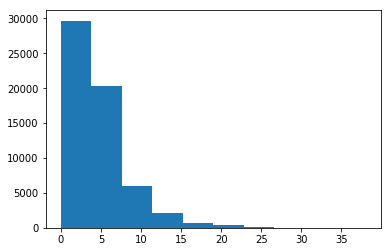

In [40]:
plt.hist((df_player['Shots'].apply(lambda x: x.split()).apply(len).values))
plt.show()

So far, our features do not capture the order in which shots occurred. But this is clearly useful information!

In [90]:
player_ord_shots = []

for rl in df_player[['Shots1', 'Shots0', 'Server']].values:
        # Adding a null feature vector to make the chosen player features always be in the first position
        if rl[2] == 0:
            rl[0] = 'K ' + rl[0]
            
        rl1split = rl[0].split()
        rl2split = rl[1].split()
        
        # Padding the sequences of shots
        rl1split += [' K']*(20 - len(rl1split))
        rl2split += [' K']*(20 - len(rl2split))
        
        # Merging the shots of the player and the opponent
        features = np.hstack((vectorizer.transform(rl1split).toarray(), vectorizer.transform(rl2split).toarray()))
        player_ord_shots.append(features)

In [94]:
player_ord_shots[0].shape

(20, 210)

We are now in a position to train a CNN on **ordered** sequences of shots!

In [95]:
features_shape = player_ord_shots[0].shape

# Reshape features to input them to the 1d CNN
ord_features = np.reshape(player_ord_shots, (-1, features_shape[0], features_shape[1]))

# Train-test split
train_x, test_x, train_y, test_y = train_test_split(ord_features, y)

# Create and train the model
model = cnn_model()
model.fit(train_x, train_y, validation_data = (test_x, test_y), epochs=5)

Train on 44619 samples, validate on 14873 samples
Epoch 1/5
44619/44619 [==============================] - 11s 240us/step - loss: 0.4823 - acc: 0.7677 - val_loss: 0.4277 - val_acc: 0.8027
Epoch 2/5
44619/44619 [==============================] - 10s 235us/step - loss: 0.4041 - acc: 0.8135 - val_loss: 0.4059 - val_acc: 0.8127
Epoch 3/5
44619/44619 [==============================] - 11s 247us/step - loss: 0.3882 - acc: 0.8208 - val_loss: 0.4030 - val_acc: 0.8164
Epoch 4/5
44619/44619 [==============================] - 10s 226us/step - loss: 0.3758 - acc: 0.8279 - val_loss: 0.4064 - val_acc: 0.8160
Epoch 5/5
44619/44619 [==============================] - 11s 247us/step - loss: 0.3638 - acc: 0.8333 - val_loss: 0.4195 - val_acc: 0.8107


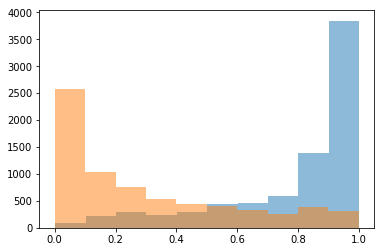

In [96]:
# Plotting the score with the ground truth labels
true_prediction_t = []
true_prediction_f = []

for n in range(len(test_x)):
    score = model.predict(np.asarray([test_x[n]]))[0][0]
    if test_y[n] == 1:    
        true_prediction_t.append(score)
    else:
        true_prediction_f.append(score)
        

plt.hist(true_prediction_t, alpha = 0.5)
plt.hist(true_prediction_f, alpha = 0.5)
plt.show()

### Recurrent approach LSTM

LSTM are normally used to predict the future behaviour of a time series or to predict the next word in an unfinished sentence. These methods train on the **past** and aim to give an estimate of the **near future**.

In our case, the LSTM takes as input the ordered sequence of shots and tries to predict the outcome of the point: the **past** is the sequence of shots and the **near future** is the outcome of the point.

In [ ]:
# Prepare data for LSTM: each entry mush be in the form (time samples, features)

player_ord_shots_lstm = []

for rl in df_player['Shots1', 'Shots0', 'Server']].values:
        #adding a null feature vector to make the chosen player features always be in position one
        if rl[2] == 1:
            rl[1] = rl[1] + ' K'
            
        rl1split = rl[0].split()
        rl2split = rl[1].split()
        #padding the sequences of shots
        rl1split = ['K ']*(20 - len(rl1split)) + rl1split
        rl2split = ['K ']*(20 - len(rl2split)) + rl2split
        #merging the shots of the player and the opponent
        features = np.hstack((vectorizer.transform(rl1split).toarray(),vectorizer.transform(rl2split).toarray()))
        player_ord_shots_lstm.append(features)
            
player_ord_shots_lstm[0].shape

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

In [ ]:
# Apply the LSTM network to ordered features

features_shape = player_ord_shots_lstm[0].shape


# Create model
model1 = Sequential()
# Add model hidden layers
model1.add(LSTM(5, input_shape = features_shape, return_sequences = True))
model1.add(Flatten())
model1.add(Dense(20, activation = "relu"))
model1.add(Dense(1, activation = "sigmoid"))

# Compile model using accuracy to measure model performance
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

ord_features = np.reshape(player_ord_shots_lstm,(-1, features_shape[0], features_shape[1]))

# Train-test split
train_x, test_x, train_y, test_y = train_test_split(ord_features, ord_labels)

# Train the model
model1.fit(train_x, train_y, validation_data = (test_x, test_y), epochs = 5)

In [ ]:
# Plotting the score with the ground truth labels
true_prediction_t = []
true_prediction_f = []

for n in range(len(test_x)):
    score = model1.predict(np.asarray([test_x[n]]))[0][0]
    if test_y[n] == 1:    
        true_prediction_t.append(score)
    else:
        true_prediction_f.append(score)
        

plt.hist(true_prediction_t, alpha = 0.5)
plt.hist(true_prediction_f, alpha = 0.5)
plt.show()

# Coaching strategies

Come up with a data-based strategy to give improving advices to Federer and Wawrinka

## Clustering


In [ ]:
# Identify break points    ###### MOVE????
def is_breakpt(pts):
    point1, point2 = pts.split('-')
    if point2 == 'AD':
        return 1
    elif point1 != 'AD' and int(point2)> int(point1) and int(point2) == 40:
        return 1
    return 0

df_player['BreakPt'] = df_player['Pts'].apply(is_breakpt)

### Butterfly point cloud in 3d for TFiDF

In [ ]:
rals, wins = df_player['Shots1'], df_player['Winner']

In [ ]:
# For simplicity, we could remove positional indications (+, -, =, ;, ^)
rals = rals.map(lambda x: re.sub(r'([\+\-\=\;\^])', '', x))

In [ ]:
# Transform rallies into one-hot vectors or TF-iDF vectors
vect = TfidfVectorizer  # CountVectorizer
vectorizer = vect(lowercase=False, analyzer='word', token_pattern='\S+', max_df=1.0, min_df=100)
X = vectorizer.fit_transform(rals).toarray()
print('Vocabulary of length {}:\n'.format(len(vectorizer.get_feature_names())), 
      vectorizer.get_feature_names()) 

In [ ]:
from sklearn.cluster import KMeans
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
labels = kmeans.labels_

for i in range(n_clusters):
    XX = wins[labels == i]
    print('Cluster {}: '.format(i), 'Population = {}'.format(len(XX)), '-- Win rate = {:.3f}'.format(XX.mean()))

In [ ]:
# Inspect cluster
rals[labels == 1][:5]

In [ ]:
# Useful library for interactive 3d plot
import plotly as py
import plotly.graph_objs as go

In [ ]:
# 3d PCA projection
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)

trace = go.Scatter3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    mode='markers',
    text=rals, #labels,             ######  REMOVE X,Z,Y, ADD RALS, LABELS, ETC. ALL TOGETHER..!!!
    marker=dict(
        size=6,
        color=wins,        # set color to an array/list of desired values
#         color=kmeans.labels_,
        colorscale='Viridis',
        opacity=0.5
    )
)
fig = go.Figure(data=[trace], layout=go.Layout(margin=dict(l=0,r=0,b=0,t=0)))
py.offline.plot(fig, filename='3d-Shots1.html')

In [ ]:
# PCA components 
features = vectorizer.get_feature_names()
for i in range(pca.n_components_):
    components_sorted = pd.Series(pca.components_[i],
                                  index=features).sort_values(ascending=False)
    print('PCA component {}: \n'.format(i),
          components_sorted[:2], '\n', components_sorted[-2:])   ###### beautify!!!!!

### Impose some constraints on the data

In [ ]:
# Select long rallies starting with '4'
constraints = (df_player['Shots1'].str.startswith('4')) & (df_player['Shots1'].str.len() > 4)
rals, wins = df_player[constraints]['Shots1'], df_player[constraints]['Winner']
len(rals)

In [ ]:
# Transform rallies into one-hot vectors or TF-iDF vectors
vect = TfidfVectorizer  # CountVectorizer
vectorizer = vect(lowercase=False, analyzer='word', token_pattern='\S+', max_df=1.0, min_df=10)
X = vectorizer.fit_transform(rals.apply(split_shots)).toarray()
print('Vocabulary of length {}:\n'.format(len(vectorizer.get_feature_names())), 
      vectorizer.get_feature_names()) 

In [ ]:
# # Could standardize features by removing the mean and scaling to unit variance
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
labels = kmeans.labels_

for i in range(n_clusters):
    XX = wins[labels == i]
    print('Cluster {}: '.format(i), 'Population = {}'.format(len(XX)), '-- Win rate = {:.3f}'.format(XX.mean()))

In [ ]:
# Inspecrt cluster
rals[labels == 2][:5]

In [ ]:
# 3d plot
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)

trace = go.Scatter3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    mode='markers',
    text=rals, #labels, 
    marker=dict(
        size=6,
#         color=wins,        # set color to an array/list
        color=labels,
        colorscale='Viridis',
        opacity=0.5
    )
)
fig = go.Figure(data=[trace], layout=go.Layout(margin=dict(l=0,r=0,b=0,t=0)))
py.offline.plot(fig, filename='3d-Direction.html')

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_pca)
labels = kmeans.labels_

for i in range(n_clusters):
    XX = wins[labels == i]
    print('Cluster {}: '.format(i), 'Population = {}'.format(len(XX)), '-- Win rate = {:.3f}'.format(XX.mean()))

### Conclusion
Cluster 2 has high win rate, probably due to the presence of f+3 attacks.

# Time series for matches

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
match_ids = df_player['match_id'].unique()
len(match_ids)

In [ ]:
# Remove matches with forfeits
last_set_winner = []
for i in range(len(match_ids)):    ###### USE GROUPBY!?
    set_winner = df_player[df_player['match_id']==match_ids[i]]['SetW'].iloc[-1:].values[0]
    last_set_winner.append(set_winner)
match_ids = [match_ids[i] for i in range(len(match_ids)) if last_set_winner[i] != 0]
len(match_ids)

In [ ]:
# Match winner: {0: player won match, 1: player lost match}
match_winner = [df_player[df_player['match_id']==m_id]['Winner'].iloc[-1:].values[0] for m_id in match_ids]
len(match_winner)

In [ ]:
# Momentum (number of pts won - number of pts lost)
def momentum(match):
    Win = df_player[df_player['match_id']==match]['Winner'].replace(0,-1)
    CumSum = Win.cumsum()
    return CumSum.reset_index(drop=True).rename(match)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(momentum(match_ids[1]))
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
for i in range(len(match_ids)):  ##### larger fig
    colors = ['r', 'g']
    plt.plot(momentum(match_ids[i]), c=colors[match_winner[i]])
plt.show()

In [ ]:
# Select momenta for beginning (first n_steps points) of tight matches (ending with abs(momentum) < bdry)
n_steps = 200
bdry = 10
list_momenta = []
list_win = []
for i in range(len(match_ids)):
    mom = momentum(match_ids[i])
    if len(mom) > n_steps and -bdry < mom.iloc[-1] < bdry:
        list_momenta.append(mom[:n_steps])
        list_win.append(match_winner[i])
df_momenta = pd.concat(list_momenta, axis=1).T
print('Number of matches selected:', len(list_momenta))
df_momenta.head()

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(len(list_momenta)):
    plt.plot(df_momenta.iloc[i])
plt.show()

In [ ]:
# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(df_momenta, 'ward')
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z)

In [ ]:
Z = linkage(df_momenta, method='complete', metric='correlation')
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z)
plt.show()

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Plot k clusters from linkage matrix Z
def plot_clusters(df, Z, k, plot=False):        ###### CHECK, REWRITE!!
    fc = fcluster(Z, k, criterion='maxclust')
    s = pd.Series(fc)
    clusters = s.unique()

    for cluster in clusters:
        cluster_indices = s[s==cluster].index
        print('Cluster {} ({} members):'.format(cluster, len(cluster_indices)))    ##### PRINT WIN RATE!!!
        if plot:
            colors = ['r', 'g']
            df.T.iloc[:,cluster_indices].plot(legend=None, color=[colors[list_win[i]] for i in cluster_indices])
            plt.ylim(-15, 15)
            plt.show()
            
plot_clusters(df_momenta, Z, 4, plot=True)

In [ ]:
sum(list_win)/len(list_win)

### Conclusion
There are clusters with high winning rate!

# Time series for tournament / career

Plot statistics like 1st/2nd serve rate, number of winner shots, forced/unforced error, aces, forehands/backhands, directions, positions...

### Match statistics

Aces

Double Faults

1st Serve In %

1st Serve Points Won

2nd Serve Points Won

Service Points Won

Total Points Won

Break Points Won



Winners

Unforced Errors

Net Points Won


Overall


Points Won, 0-4 Shots

Points Won, 5-9 Shots

Points Won, 10+ Shots


Most Consec Pts Won

Last Ten Points

Longest rally

In [ ]:
# GROUPBY APPROACH...

In [ ]:
# balance between 1st and 2nd serves... aces vs double faults

# Reinforcement learning

Create a world-model on say Nadal, then train an RL agent to find the optimal strategy. 

How to ensure that the agent won't systematically recommend impossible shots (volleys on returns, net shots...)????

In [ ]:
# Select games of 'player' against 'opponent'
opponent_name = 'Rafael_Nadal'
df_po = df_player[(df_player['Player1'] == opponent_name) | (df_player['Player2'] == opponent_name)]  
print(len(df_po))

In [ ]:
df_po.head(4)

In [ ]:
# Build 3-grams of sequential shots for player (p) and opponent (o)  

from nltk import ngrams

shots_opo = []

for i in range(len(df_po)):
    shots = df_po['Shots'].iloc[i]
    length = len(shots.split())
    server = df_po['Server'].iloc[i]
    
    if server == 1: 
        if length%2==0:
            z = '' 
        else:
            z = ' '
        # 'X' for waiting to receive serve
        sentence = 'X ' + df_po['Shots'].iloc[i] + z + df_po['Outcome'].iloc[i]
        n_grams = list(ngrams(sentence.split(), 3))
        shots_opo.extend(n_grams[0::2])
        
    if server == 0: 
        if length%2==0:
            z = ' ' 
        else:
            z = ''
        # 'X' for waiting to receive serve
        sentence = 'X ' + df_po['Shots'].iloc[i] + z + df_po['Outcome'].iloc[i]
        n_grams = list(ngrams(sentence.split(), 3))
        shots_opo.extend(n_grams[1::2])
        
print('OPO: {}'.format(len(shots_opo)))

In [ ]:
shots_opo[:9]

In [ ]:
# Possible states (omit rare shots)
from collections import Counter

states_counts = Counter(list(sum(shots_opo, ()))).most_common(100)
states = [state[0] for state in states_counts]
print('{} possible states:\n'.format(len(states)), states) 

# Remove triples containing uncommon shots
shots_opo_com = [x for x in shots_opo if x[0] in states and x[1] in states and x[2] in states]  #### BEAUTIFY! INTERSECTION..

In [ ]:
# Possible actions (omit rare shots)
vectorizer = CountVectorizer(lowercase=False, analyzer='word', token_pattern='\S+', 
                             max_df=1.0, min_df=100)
vectorizer.fit('X ' + df_po['Shots'])
actions = vectorizer.get_feature_names()
print('{} possible actions:\n'.format(len(actions)), actions) 

In [ ]:
# Model based on opponent's style
# Given current state s_t and action a_t, return next state s_t+1
def model(state, action):
    n_grams_sa = [n_gram for n_gram in shots_opo_com if n_gram[0]==state and n_gram[1]==action]
    if(len(n_grams_sa) > 1):    # exclude rare reactions
        return np.random.choice([n_gram[2] for n_gram in n_grams_sa])
    return 'n@'   # when (s,a) never happened, return unforced error in net

# Example
model('5', 'f28')

In [ ]:
# Check whether a state is win (1), lose (0), or neither (-1)
def is_win(state):
    if state == '*':
        return 1
    elif '*' in state:
        return 0
    if state[0] in ['n','w','d','x','g','e','!','#','@']:
        return 0
    elif state[-1] in ['n','w','d','x','g','e','!','#','@']:
        return 1
    return -1   # neither won nor lost

In [ ]:
# Your turn to serve against the AI tennis opponent!

current_state = 'X'
while True:       ###### CAREFUL WHEN INTERRUPTING
    shot = input()
    next_state = model(current_state, shot)
    print(next_state)
    current_state = next_state
    if is_win(next_state) == 1:
        print('Winner!')
        break
    if is_win(next_state) == 0:
        print('Loser!')
        break

### Q-learning algorithm

The purpose of the Q-learning algorithm is to obtain the quality function **Q(state,action)**. This function will be used to obtain the optimal policy **p(s)=argmax_a(Q(s,a))**: the policy defines the agent's behaviour. Indeed, given a state s at which the agent is found, **p(s)** corresponds to the best action the agent could perform from that state. 

The Q-learning algorithm finds the quality function **Q(s,a)** by *exploring* the state-action space: in our case, our agent plays tennis at random and gets rewarded depending on the future outcome of the point played. 

The Q-function update is given by the following formula:

**Q(s,a)   <---   (1-alpha) Q(s,a) + alpha [r(s,s') + gamma * max_a Q(s',a)],**

where **gamma** is the discount factor and **alpha** is the learning parameter. These hyperparameters are to be chosen empirically. 

In [ ]:
# Reward function r(s,s')
def reward(current_state, next_state):
    if is_win(current_state) == 1:   ###### SUSPICIOUS?!?!  NEVER USED!??!
        return 10
    if is_win(current_state) == 0:
        return -10
    if is_win(next_state) == 1:
        return 20
    if is_win(next_state) == 0:
        return -20
    return -1

In [ ]:
reward('f3', 'b1')

In [ ]:
shots_opo_com[:15]

In [ ]:
# Initialize the Q-matrix
n_episodes = 20000
Q = np.zeros((len(states),len(actions)))   ###### RANDOM INITIALIZATION??

# Policy function
def policy(state):
    row = Q[states.index(state),:]
    argmaxi = np.argmax(row)
    return actions[argmaxi]

# Initialize maxima of Q over all possible actions, given the current state
maxima = [0] * len(states)

# Hyperparameters
alpha = 0.3   # learning rate
gamma = 0.1   # discount factor
epsilon = 0.1   # for epsilon-greedy policy

serves_opponent = [shot for shot in [sh[0] for sh in shots_opo_com] if shot[0] in '456']

# Exploration procedure
print('Episode number:')
for episode in range(n_episodes):
    print( episode, end='\r')
    # Random choice of server
    if np.random.randint(0,2) == 1:
        current_state = 'X'
    else:
        current_state = np.random.choice(serves_opponent)
    # Play shot by shot
    for step in range(100):       ##### WHILE TRUE???
        if np.random.random() < epsilon:   # Exploration in epsilon % of cases
            action = np.random.choice(actions)
        else:
            action = policy(current_state)
        next_state = model(current_state, action)   # Get opponent's reaction
        # Update Q        
        s = states.index(current_state)
        a = actions.index(action)
        r = reward(current_state, next_state)
        max_aQ = maxima[states.index(next_state)]
        Q[s,a] = (1 - alpha)*Q[s,a] + alpha*(r + gamma*max_aQ)
        maxima[s] = max(maxima[s], Q[s,a])
        current_state = next_state
        if is_win(current_state) == 1:
            break
        if is_win(current_state) == 0:
            break

In [ ]:
# Saving the trained Q-matrix
# Q_trained = Q.copy()
# np.save('RL_trained_Q2',Q_trained)
plt.hist(Q[states.index('f3'),:],20)
plt.show

In [ ]:
# Plot the Q-matrix
import seaborn as sns
plt.figure(figsize=(20,20))
a=sns.heatmap(Q)

plt.show()

In [ ]:
print('state: ', states[23],'action: ',actions[19])
print('state: ', states[35],'action: ',actions[20])
print('state: ', states[41],'action: ',actions[36])
print('state: ', states[76],'action: ',actions[38])
print('state: ', states[48],'action: ',actions[38])

In [ ]:
# Optimized RF plays against historical RN !!
points_won = 0
points_lost = 0

for num in range(5000):
    print(num, end='\r')
    #random choice on who is serving
    if np.random.randint(0,2) == 0 :
        current_state = 'X'
    else :
        current_state = np.random.choice(serves_opponent)
    for n in range(100):
        shot = policy(current_state)
        next_state = model(current_state,shot)
        reward(current_state,next_state)
        #print('to ', shot, 'RN replied with: ', current_state )
        current_state = next_state
        if is_win(current_state) == 1:
            points_won += 1
            break
        if is_win(current_state) == 0:
            points_lost += 1
            break
            
print('How well are we performing? ', points_won/(points_lost+points_won))
print('Baseline performance: ',1-(df_po['Winner'].sum()/len(df_po['Winner'])))